# IR1 - Programming Assignment - Part B
#### Elias Kassapis (12409782)
#### Stijn Verdenius (10470654)
#### Konstantin Todorov (12402559)

## Introduction
In this notebook an experiment is implemented, with the goal to obtain the number of interleaving impressions necessary to statistically say ranking algorithm E outperforms current standard algorithm P. To reach this goal a class structure has been set up that produces a table with the needed number of online impressions, given the initial offline ERR-score interval in offline testing. This is done in six steps:

- Step 1: Generating ranking pairs for E & P, using all possible permutations of a number of documents with binary relevance
- Step 2: Filtering the generated ranking pairs on the part that produces promising results for E only. Subsequently dividing in bins of small intervals of ERR-score.
- Step 3: Creating interleavings from these intervals with two models: team-draft- and probabilistic interleaving
- Step 4: Learning to imitate user behaviour using actual user log-files, and therewith training a probabilistic- and random click model
- Step 5: Combining Interleaving and Click models to do experiment in parallel fashion
- Step 6: Using results to obtain needed number of impressions for statistical significance

The Experiment has been set up using a number of classes, each representing a part of the experiment. For example, there are classes for interleavings and click models, as well as for each step in the process. Subsequently, all classes are combined in the main function, making sure the setup is modular, thus allowing quick changes to be made. Finally, results are demonstrated and analysed, to validate the effectivness of the PBM, comparte the effect of the interleaving algorithms and finally to compare sample size.

Directly underneath the code can be found with chapters corresponding to the steps mentioned above, after which the analysis can be found.

In [ ]:
### IMPORTS

import numpy as np
import itertools
from typing import List
from functools import lru_cache
from copy import deepcopy
from random import choice, random
import random
from scipy.stats import norm
import pickle
import multiprocessing as mp
import math
import scipy.stats
import cProfile, pstats, io
import os


# ### DEBUG MODE
# # to add debugging, open terminal and type 'tail -1000f debug.txt'. Also uncomment next line
# debug = open("debug.txt", "w")
# # you can then write to terminal with the following python command: debug.write("something \n")


### GLOBAL CONSTANTS

# Caching
CACHING_ON = False

# Number of docs created
DATABASE_SIZE = 6

# Gamma's get trained on this many docs:
GAMMA_SIZE = 3 # also defines cutoff


### UTILS

def softmax(distribution):
    """ used to restore probability constraint of summing to 1 when elements are removed """

    summation = sum(distribution)
    return [float(x / summation) for x in distribution]

@lru_cache(maxsize=3200)
def difference_to_err_table_position(difference: float) -> int:
    # if difference < 0.05 or 
    if difference > 0.95:
        raise Exception("Invalid difference")
    elif difference < 0.1:
        return 0
    elif difference < 0.2:
        return 1
    elif difference < 0.3:
        return 2
    elif difference < 0.4:
        return 3
    elif difference < 0.5:
        return 4
    elif difference < 0.6:
        return 5
    elif difference < 0.7:
        return 6
    elif difference < 0.8:
        return 7
    elif difference < 0.9:
        return 8
    else:
        return 9

def initialize_err_table():
    err_table = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: [],
        6: [],
        7: [],
        8: [],
        9: []
    }

    return err_table

# check
if (GAMMA_SIZE > 10):
    GAMMA_SIZE = 10
elif (GAMMA_SIZE < 1):
    GAMMA_SIZE = 1
    

def split_to_chunks(list_to_split, chunks_size):
    """Yield successive n-sized chunks from l."""
    chunks = []
    for i in range(0, len(list_to_split), chunks_size):
        chunks.append(list_to_split[i:i + chunks_size])
    
    return chunks

def average_chunks(list_to_split, max_chunks):
    chunks_size = math.ceil(len(list_to_split) / max_chunks)
    chunks = split_to_chunks(list_to_split, chunks_size)

    result = []
    for chunk in chunks:
        chunk_average = np.average(chunk)
        result.append(chunk_average)

    return result

In [ ]:
### DATA MANAGEMENT

class Saver():

    def __init__(self, directory, caching=False):
        self.directory = directory
        self.caching = caching
        self.notified = False

    def save_python_obj(self, obj, name):
        if (not self.caching):
            if (not self.notified):
                print("WARNING: caching disabled, nothing will be pickled. See boolean CACHING_ON on top of notebook")
                self.notified = True
            return
            
        try:
            with open(self.directory + name+".pickle", 'wb') as handle:
                pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print("Saved {}".format(name))
        except:
            print("Failed saving {}, continue anyway".format(name))

    def load_python_obj(self, name):
        if (not self.caching):
            if (not self.notified):
                print("WARNING: caching disabled, nothing will be pickled. See boolean CACHING_ON on top of notebook")
                self.notified = True
            raise FileNotFoundError("Caching disabled")
        
        obj = None
        try:
            with (open(self.directory + name+".pickle", "rb")) as openfile:
                obj = pickle.load(openfile)
        except FileNotFoundError:
            raise FileNotFoundError("{} not loaded because file is missing".format(name))
        print("Loaded {}".format(name))
        return obj

    def load_data_model_1(self):
        try:
            frame = self.load_python_obj("data_model_1")
            print("Loaded sucessfully")
            return frame
        except FileNotFoundError:

            print("Building data framework")

            f = open(self.directory+"YandexRelPredChallenge.txt", "r")
            frame = []
            for line in f:

                line = line.replace("\n", "")

                elements = line.split("	")

                if (elements[2] == "C"):
                    dictionary = {"SessionID": int(elements[0]),
                                  "TimePassed": int(elements[1]),
                                  "TypeOfAction": elements[2],
                                  "URLID": int(elements[3])}
                elif (elements[2] == "Q"):
                    dictionary = {"SessionID": int(elements[0]),
                                  "TimePassed": int(elements[1]),
                                  "TypeOfAction": elements[2],
                                  "QueryID": int(elements[3]),
                                  "RegionID": int(elements[4]),
                                  "ListOfURLs": [int(x) for x in elements[5:5+GAMMA_SIZE]]

                                  }
                else:
                    raise Exception("contenttype not recognized, check load data function")

                frame.append(dictionary)

            self.save_python_obj(frame, "data_model_1")

            print("Created data model, this only needs to be done once if caching is on")
            return frame

### General IR-step class
used to define the process structure

In [ ]:
class IRStep(object):

    def __init__(self, name=None, purpose=None, data=None):
        self.name = name
        self.purpose = purpose
        self.data = data

    def do_step(self, input_list):
        print("Starting step {}".format(self.name))
        if (not self.purpose == None):
            print("Goal:" + self.purpose + "\n\n")

        result = self.onStart(input_list)
        self.onfinish()
        
        return result

    def onStart(self, input_list):
        raise Exception("method to be overrided by subclass Step#")

    def onfinish(self):
        raise Exception("method to be overrided by subclass Step#")

### Step 1 implementation:
- Getting the rankings out of permutations
- Creating the documents
- Pairing up

In [ ]:
class Document(object):
    
    def __init__(self, id, relevance : int):
        self.id = id
        self.relevance = relevance

    def __str__(self):
        return str({"relevance" : self.relevance_to_int(), "id": self.id})
        
    def relevance_to_int(self):
        return self.relevance
        

In [ ]:
class RankingsStep(IRStep):

    def __init__(self, name, purpose, data):
        super().__init__(name, purpose, data)

    def onStart(self, input_list):
        print("--- generating documents...")

        documents = self.generate_documents(input_list[0])

        print("--- generating rankings...")
        p_rankings = itertools.permutations(documents, r=3)
        e_rankings = itertools.permutations(documents, r=3)
        
        print("--- generating ranking pairs...")
        rankings_pairs = list(itertools.product(p_rankings, e_rankings))
        rankings_pairs = [(list(item[0]), list(item[1])) for item in rankings_pairs]

        print(f'--- finished generating {len(rankings_pairs)} ranking pairs')
                
        return rankings_pairs

    def onfinish(self):
        print("\n\nFinished step {}\n\n".format(self.name))

    def generate_documents(self, number) -> List[Document]:
        current_id = 1
        documents = []
        
        # create NOT_RELEVANT documents 
        for i in range(number):
            documents.append(Document(current_id, 0))
            current_id += 1

        # create RELEVANT documents
        for i in range(number):
            documents.append(Document(current_id, 1))
            current_id += 1

        return documents


### Step 2 implementation:
- Evaluating EER score
- Binnify pairs
- Filtering not promising results

In [ ]:
class ERRStep(IRStep):

    def __init__(self, name, purpose, data):
        super().__init__(name, purpose, data)

    def onStart(self, ranking_pairs):
        err_table = initialize_err_table()
        
        counter = 0
        for ranking_pair in ranking_pairs:

            try:
                p_err = self.calculate_err(ranking_pair[0])
                e_err = self.calculate_err(ranking_pair[1])

                difference = e_err - p_err

                # if E does not outperform P, discard this pair
                if difference <= 0:
                    continue
                counter += 1

            except:
                continue

            err_table_position = difference_to_err_table_position(difference)
            err_table[err_table_position].append(ranking_pair)

#             # DEBUG LINE FOR GETTING LESS DOCS
#             if counter >= 100:
#                 break

        print (f'total ranking pairs left: {counter}')
        
        return err_table

    def onfinish(self):
        print("Finished step {}".format(self.name))

    def calculate_err(self, documents: [Document]):
        err_score = 0

        max_relevance = 0
        for document in documents:
            document_relevance = document.relevance_to_int()
            if document_relevance > max_relevance:
                max_relevance = document_relevance

        for r, document in enumerate(documents):
            inner_result = 1
            for i in range(r):
                theta_i = (2**(documents[i].relevance_to_int()) - 1)/ (2**(max_relevance))
                inner_result *= (1 - theta_i)
        
            theta_r = (2**(document.relevance_to_int()) - 1)/ (2**(max_relevance))
            current_err_score = inner_result * theta_r
            current_err_score /= (r + 1)
            
            err_score += current_err_score
        
        return err_score

### Step 3 implementation:
- Interleaving ranking pairs using the following models:
    - Team draft interleaving
    - Probabilistic interleaving

In [ ]:

"""
Main interleaving class, parent to specific interleavings

Holds some main functionality
"""

class Interleaving(object):


    def __init__(self, alg_P, alg_E, cutoff=None):
        self.alg_P = alg_P
        self.alg_E = alg_E
        self.ranking2algorithm = {0: "P", 1: "E"}
        self.position2ranking = {}
        self.interleaved = []
        self.score = {"E" : 0, "P" : 0}
        self._interleave_docs()
        if (not cutoff == None):
            self.cut_off_at(cutoff)
        self.registered_clicks = 0
        self.click_history = []

    def _interleave_docs(self): #PRIVATE
        """ method contracty to be overrided by child-classes """

        raise NotImplementedError("To be overrided by child class")

    def insertclick(self, position): 
        """ stores a click in the interleaving such that later the score can be extracted """

        self.score[self.ranking2algorithm[self.position2ranking[position]]] += 1
        self.registered_clicks += 1
        self.click_history.append(position)

    def get_interleaved_ranking(self) -> List[Document]: 
        """ returns list of documents """

        return self.interleaved

    def get_click_history(self): 
        return self.click_history

    def get_score(self): 
        """ returns the score of the two isnerted rankings given currently registered clicks """

        return self.score

    def reset_score(self): 
        """ resets counters but leaves interleaving intact """

        self.score = {"E": 0, "P": 0}
        self.registered_clicks = 0
        self.click_history = []

    def get_winner(self): 
        """ gets winner of interleaving """

        if (self.score["E"] == self.score["P"]):
            return -1
        return max(self.score, key=self.score.get)

    def cut_off_at(self, cutoff): 
        """ cuts off interleaving after certain rank. note: expectations are not recalculated """

        self.interleaved = self.interleaved[:cutoff]
        for key in list(self.position2ranking):
            if (key > cutoff):
                del self.position2ranking[key]

    def _remove_duplicates_from_other_ranking(self, rankings, picked_document, counters, which_second, distributions=None): #PRIVATE
        """ buisiness logic function for removing duplicates out of the ranking whos turn it is not to add a element to the interleaving """

        # get doc ids from the other ranking and see at what places the doc occurs
        doc_ids_second_player = [doc.id for doc in rankings[which_second]]

        if (picked_document.id in doc_ids_second_player):
            index = doc_ids_second_player.index( picked_document.id)

            removed = rankings[which_second].pop(index)
            counters[which_second] -= 1

            # make sure the removed objects ar identical
            assert removed.id == picked_document.id, "Mistake in prob-interleaving: removing docs from other ranking"

            return self._pop_distribution(index, distributions, which_second)
        else:
            return 0

    def _pop_distribution(self, index, distributions, which_second): #PRIVATE
        """ to be overrided by child-classes that utilize it, to be ignored by those who don't """

        pass

    def __str__(self): #TO STRING
        return "Interleaving: " + str(self.get_interleaved_ranking()) + ", Scores: " + str(self.score), ", Registered clicks: "+ str(self.registered_clicks)

In [ ]:

class ProbabilisticInterleaving(Interleaving):

    def __init__(self, alg_P, alg_E, distribution, cutoff=None):
        self.distribution = distribution
        assert len(distribution) == len(alg_P) == len(
            alg_E), "rankings and/or distribution not fo the same lengths"
        self.possible_generators = len(alg_P) * len(alg_E)
        self.position2chance = {}
        super().__init__(alg_P, alg_E, cutoff)


    def _interleave_docs(self): #PRIVATE
        """ implementation of interleaving """

        counters = [len(self.alg_P), len(self.alg_E)]
        rankings = deepcopy([self.alg_P, self.alg_E])
        distributions = deepcopy([self.distribution])+deepcopy([self.distribution])

        while (sum(counters) > 0):

            # flip coin
            which_first = choice([1, 0])
            which_second = int(not which_first)

            # take doc from chosen ranking, skip if it is empty
            if (counters[which_first] == 0):
                continue
            counters[which_first] -= 1
            picked_index = np.random.choice(range(len(distributions[which_first])), p=softmax(distributions[which_first]), replace=False)
            picked_document = rankings[which_first].pop(picked_index)
            chance_which_first = self._pop_distribution(picked_index, distributions, which_first)

            # remove from other ranking
            chance_which_second = self._remove_duplicates_from_other_ranking(rankings, picked_document, counters, which_second, distributions=distributions)

            # insert into interleaving
            self.position2chance[len(self.interleaved)] = {which_first: chance_which_first, which_second: chance_which_second}
            self.interleaved.append(picked_document)

        # make sure both rankings are empty
        assert len(rankings[0]) + len(rankings[1]) == 0, "Mistake: not ranking all docs"

        # complete expectation calculation
        self._fill_in_expectations()



    def insertclick(self, position): # USE THIS
        """ implementation of click-saving """

        self.score["P"] += self.position2ranking[position][0]
        self.score["E"] += self.position2ranking[position][1]

        self.registered_clicks += 1
        self.click_history.append(position)

    def _pop_distribution(self, index, distributions, which): # PRIVATE
        """ removes element form probability distribution as to be consistent with the documents to be interleaved"""

        return distributions[which].pop(index)

    def _fill_in_expectations(self): # PRIVATE
        """ pre-calculates the expectation that is added to both players per new future click """

        # get all permutations that could've generated this interleaving
        chance_of_permutations = []
        contribution_permutations = list(itertools.product([0, 1], repeat=len(self.interleaved)))

        # get the prior chance of that permutation
        for permutation in contribution_permutations:
            chance_of_permutations.append(float(sum([self.position2chance[i][r] for i, r in zip(range(len(self.interleaved)), permutation)])/(self.possible_generators*0.5)))

        # for both rankings, calculate expectated clicks earned for each future click on each position
        for position in range(len(self.interleaved)):

            expectations = [0,0]

            for chance, permutation in zip(chance_of_permutations, contribution_permutations):
                expectations[permutation[position]] += self.position2chance[position][permutation[position]]*chance

            self.position2ranking[position] = {0: expectations[0], 1 : expectations[1]}

In [ ]:
class TeamDraftInterleaving(Interleaving):

    def __init__(self, alg_P, alg_E, cutoff=None):
        super().__init__(alg_P, alg_E, cutoff)

    def _interleave_docs(self): # PRIVATE
        """ implementation of interleaving """

        counters = [len(self.alg_P), len(self.alg_E)]
        rankings = deepcopy([self.alg_P, self.alg_E])

        while(sum(counters) > 0):

            # flip coin
            which_first = choice([1, 0])
            which_second = int(not which_first)

            # take doc from chosen ranking, skip if it is empty
            if (counters[which_first] == 0):
                continue
            counters[which_first] -= 1
            picked_document = rankings[which_first].pop(0)

            self._remove_duplicates_from_other_ranking(rankings, picked_document, counters, which_second)

            # insert into interleaving
            self.position2ranking[len(self.interleaved)] = which_first
            self.interleaved.append(picked_document)

        # make sure both rankings are empty
        assert len(rankings[0]) + len(rankings[1]) == 0, "Mistake: not ranking all docs"


In [ ]:
class InterleavingsStep(IRStep):

    def __init__(self, name, purpose, data):
        self.distribution = []
        super().__init__(name, purpose, data)

    def onStart(self, input_list):

        saver = Saver("", caching=CACHING_ON)

        try:

            return_dict = saver.load_python_obj("interleavings")
            return return_dict
        except:


            probabilistic_interleavings_list = []
            team_draft_interleavings_list = []
            self.distribution = softmax([norm.pdf(x, 0, 1.5) for x in range(3)])

            for number, category in enumerate(input_list.values()):
                print ("\nStart interleaving category {}".format(number))

                local_probabilistic_interleavings_list = []
                local_team_draft_interleavings_list = []


                for pair_number, (ranking1, ranking2) in enumerate(category):

                    if ((pair_number % int(len(category)/10)) == 0):
                        print("\r{} out of {} done".format(pair_number,  len(category)), end='')

                    try:
                        probabilistic_interleaving = ProbabilisticInterleaving(ranking1, ranking2, self.distribution)
                        probabilistic_interleaving.cut_off_at(GAMMA_SIZE)
                        local_probabilistic_interleavings_list.append(probabilistic_interleaving)
                    except:
                        pass

                    try:
                        draft_interleaving = TeamDraftInterleaving(ranking1, ranking2)
                        draft_interleaving.cut_off_at(GAMMA_SIZE)
                        local_team_draft_interleavings_list.append(draft_interleaving)
                    except:
                        pass

                probabilistic_interleavings_list.append(local_probabilistic_interleavings_list)
                team_draft_interleavings_list.append(local_team_draft_interleavings_list)

            print("\n\n")

            return_dict = {"probabilistic": probabilistic_interleavings_list, "team_draft": team_draft_interleavings_list}
            saver.save_python_obj(return_dict, "interleavings")
            return return_dict

    def onfinish(self):
        print("Finished step {}".format(self.name))

### Step 4 implementation:
- Learning click model parameters for user-simulation using EM and ML
- Defining click models

In [ ]:

class Click_Model(object):

    def __init__(self, parameters, data):
        self.parameters = parameters
        self.data = data


    def train(self):
        raise NotImplementedError("to be overrided")

    def apply(self, interleaving):
        raise NotImplementedError("to be overrided")

    def get_sc(self):  # clicks for each session
        """
        :param data - in the form of a list of libraries
        :return - library where key = Session ID, value = query:[rank, url,click]
        """
        sc = {}  # key = Session ID, value = (clicked rank, url)
        current_q = {}
        for i in self.data:
            if i["SessionID"] not in sc.keys():
                sc[i['SessionID']] = {i['QueryID']: []}

            if i['TypeOfAction'] == 'Q':
                if i['QueryID'] not in sc[i["SessionID"]].keys():
                    sc[i['SessionID']][i['QueryID']] = []  # Empty if session does not result in click
                current_q = {"SessionID": i["SessionID"], "QueryID": i['QueryID'], "ListOfURLs": i["ListOfURLs"]}
                for r, u in enumerate(i["ListOfURLs"]):
                    sc[i['SessionID']][i['QueryID']].append([r + 1, u, False])
            if i['TypeOfAction'] == 'C':
                try:
                    cur_q = current_q["ListOfURLs"]
                except:
                    continue
                for r, u in enumerate(cur_q):
                    if u == i["URLID"]:
                        for sublist in sc[i['SessionID']][current_q['QueryID']]:
                            if sublist[1] == u:
                                sublist[2] = True
        return sc



In [ ]:

class PBM(Click_Model):

    def __init__(self, parameters, data):
        super().__init__(parameters, data)


    def train(self):
        print("Starting training")

        uq = self.get_uq()  # change frame to whatever is the data saved as
        sc = self.get_sc()
        alphas = self.init_alphas(0.2)  # initializing first alpha
        # gammas = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
        gammas = self.parameters
        gs = [gammas]
        als = [alphas]
        convergence_e = 0.01
        counter = 0

        while 1 == 1:  # infinite loop
            current_g = self.gamma_update(als[-1], gs[-1], uq, sc)
            # current_g = gamma_update(alphas, gs[counter], uq, sc)
            gs.append(current_g)

            current_a = self.alpha_update(als[-1], gs[-1], uq, sc)
            als.append(current_a)

            if (len(als) > 3):
                als.pop(0)

            if (len(gs) > 3):
                gs.pop(0)

            counter += 1
            print('\rEM iteration number = {} Trained parameters = {}'.format(counter, current_g), end='')
            if np.linalg.norm(np.array(gs[-1]) - np.array(gs[-2])) < convergence_e and counter > 0:  # Convergence criteria
                print("\n")
                self.parameters = current_g
                return

    def apply(self, interleaving):


        interleaving.reset_score()

        epsilon = 1e-6
        interleaving_list = interleaving.get_interleaved_ranking()

        for index, document in enumerate(interleaving_list):
            relevance = document.relevance_to_int()
            if relevance == 1:
                alpha = 1 - epsilon
            else:
                alpha = epsilon

            dice = random.random()

            evaluated = self.parameters[index] * alpha

            if dice <= evaluated:
                interleaving.insertclick(index)

    def get_uq(self):
        """
        :param data - in the form of a list of libraries
        :return - library with key = document url, value = Query id: list of sessions
        """
        uq = {}  # key = document url, value = Query id: list of sessions
        for i in self.data:
            if i['TypeOfAction'] == 'Q':
                for u in i['ListOfURLs']:
                    if u not in uq.keys():
                        uq[u] = {i['QueryID']: [i['SessionID']]}  # add url and corresponding query and session id
                    if u in uq.keys():
                        if i['QueryID'] in uq[u].keys():  # check if document vs. query combo already exists
                            uq[u][i['QueryID']].append(i['SessionID'])
                        else:
                            uq[u][i['QueryID']] = [i['SessionID']]
        return uq



    def init_alphas(self, value):
        """
        :param data -  in the form of a list of libraries
        :return - library where key = document, value = query : a_uq
        """
        alphas = {}  # key = document, value = query : a_uq
        for f in self.data:
            if f['TypeOfAction'] == 'Q':
                for u in f["ListOfURLs"]:
                    if u not in alphas.keys():
                        alphas[u] = {f['QueryID']: value}
                    if u in alphas.keys():
                        if f['QueryID'] not in alphas[u].keys():
                            alphas[u][f['QueryID']] = value
        return alphas

    def alpha_update(self, alphas, gammas, uq, sc):
        """
        :param alphas - library where key = document, value = query : a_uq
        :param gammas - list of 10 parameters
        :param uq - library with key = document url, value = Query id: list of sessions
        :param sc - library where key = Session ID, value = (clicked rank, url)
        :return - update by iterating though all query vs. document seshs
        """
        alpha2 = self.init_alphas(1)
        rank = 1  # init rank
        click = 0  # initialize click

        for document in uq:
            for query in uq[document]:
                counter = 2

                for session in uq[document][query]:
                    counter += 1
                    for e in sc[session][query]:
                        if document == e[1]:
                            rank = e[0]
                            if e[2] == True:
                                click = 1
                            else:
                                click = 0
                            break

                    if (click == 0):
                        fraction = ((1 - gammas[rank - 1]) * alphas[document][query]) / (
                                    1 - (gammas[rank - 1] * alphas[document][query]))  # check alphas[document][query]
                        alpha2[document][query] += fraction
                    else:
                        alpha2[document][query] += 1

                alpha2[document][query] /= counter

                if alpha2[document][query] < 0:
                    raise Exception

                if alpha2[document][query] > 1:
                    raise Exception
        return alpha2

    def gamma_update(self, alphas, gammas, uq, sc):
        """
        :param alphas - library where key = document, value = query : a_uq
        :param gammas - list of 10 parameters
        :param uq - library with key = document url, value = Query id: list of sessions
        :param sc - library where key = Session ID, value = (clicked rank, url)
        :return - list of updated parameters
        """
        s_r = {key+1 : 0 for key in range(len(gammas))}#, 7: 0, 8: 0, 9: 0, 10: 0}  # sessions per rank (counter)
        # counter = 0
        gamma = np.zeros(len(gammas))
        rank = 1  # initialize rank
        click = 0  # initialize click
        for document in uq:
            for query in uq[document]:
                for session in uq[document][query]:
                    for e in sc[session][query]:
                        if document == e[1]:
                            rank = e[0]
                            s_r[rank] += 1
                            if e[2] == True:
                                click = 1
                            else:
                                click = 0
                            break

                    if (click == 0):
                        fraction = (gammas[rank - 1] * (1 - alphas[document][query])) / (
                                    1 - gammas[rank - 1] * alphas[document][query])

                        gamma[rank - 1] += fraction
                    else:
                        gamma[rank - 1] += 1


        for g in range(len(gamma)):
            gamma[g] /= s_r[g + 1]

        return list(np.around(gamma, 4))




In [ ]:

class Random_Click_Model(Click_Model):

    def __init__(self, parameters, data):
        super().__init__(parameters, data)


    def train(self):
        print("Starting training")

        sc = self.get_sc()
        numerator = 0
        denominator = 0
        for session in sc:
            for query in sc[session]:
                for document in sc[session][query]:
                    if document[2] is True:
                        numerator += 1
                    denominator += 1

        rho = numerator / denominator

        self.parameters = rho
        print("Final rho parameter {}".format(rho))
        return


    def apply(self, interleaving):
        interleaving.reset_score()

        interleaving_list = interleaving.get_interleaved_ranking()

        for index, _ in enumerate(interleaving_list):
            if random.random() <= self.parameters:
                interleaving.insertclick(index)


In [ ]:
class UserClicksSimulationStep(IRStep):

    def __init__(self, name, purpose, data):
        super().__init__(name, purpose, data)


    def onStart(self, input_list):
        length_interleaving = input_list[0]
        save_and_load = Saver("", caching=CACHING_ON)

        pbm_model = PBM([0.2]*length_interleaving, self.data)
        try:
            print("Attempting loading gamma's from pickle")
            gammas_pbm = save_and_load.load_python_obj("gammas_pbm")
            pbm_model.parameters = gammas_pbm
        except:
            print("Did not find gamma's saved in pickle so will retrain and save")
            pbm_model.train()
            save_and_load.save_python_obj(pbm_model.parameters, "gammas_pbm")

        random_model = Random_Click_Model([0.1] * length_interleaving, self.data)
        try:
            print("Attempting loading rho's from pickle")
            rho_random = save_and_load.load_python_obj("rho_random")
            random_model.parameters = rho_random
        except:
            print("Did not find rho saved in pickle so will retrain and save")
            random_model.train()
            save_and_load.save_python_obj(random_model.parameters, "rho_random")

        return (pbm_model, random_model)

    def onfinish(self):
        print("Finished step {}".format(self.name))




### Step 5 implementation:
- Running click simulations for online testing
- Capturing experiment results

In [ ]:

class Experiment(object):
    

    def __init__(self, interleaving_interval_lists, click_model, name):
        self.win_percentage = {}
        self.interleaving_interval_lists = interleaving_interval_lists
        self.click_model = click_model
        self.name = name
        self.k = 3000

    def run(self):
        self.win_percentage = initialize_err_table()
        
        logging = True

        try:
            f = open("Console_output_multiprocess_{}.txt".format(self.name), "w")
        except:
            logging = False

        # for each interval, for each ranking pair we first 
        # run interleaving model then the click model k times
        for interval_index, interleaving_lists in enumerate(self.interleaving_interval_lists):

            if (logging):
                f.write("INTERVAL" + str(interval_index) + "\n")
                f.flush()

            self.win_percentage[interval_index] = []
            for interleaving_index, interleaving in enumerate(interleaving_lists):

                try:
                    if (logging):
                        f.write("#" + str(interleaving_index) + " out of {} in bin {}\n".format(str(len(interleaving_lists)), str(interval_index)))
                        f.flush()

                    wins = 0
                    for _ in range(self.k):
                        self.click_model.apply(interleaving)

                        winner = interleaving.get_winner()
                        if winner == "E":
                            wins += 1

                    current_pair_win_percentage = wins / self.k
                    self.win_percentage[interval_index].append(current_pair_win_percentage)

                except:
                    continue

        self.win_percentage["name"] = self.name
        if (logging):
            f.flush()
        return self.win_percentage, f, logging

In [ ]:
class InterleavingSimulationStep(IRStep):
    def __init__(self, name, purpose, data):
        super().__init__(name, purpose, data)


    def onStart(self, input_list):
        probabilistic_interleavings_list = input_list[0]["probabilistic"]
        team_draft_interleavings_list = input_list[0]["team_draft"]
        probabilistic_click_model = input_list[1]["probabilistic"]
        random_click_model = input_list[1]["random"]

        experiment_1 = Experiment((probabilistic_interleavings_list), probabilistic_click_model, 1)
        experiment_2 = Experiment((probabilistic_interleavings_list), random_click_model, 2)
        experiment_3 = Experiment((team_draft_interleavings_list), probabilistic_click_model, 3)
        experiment_4 = Experiment((team_draft_interleavings_list), random_click_model, 4)

        save_and_load = Saver("", caching=CACHING_ON)

        experiments = [experiment_1, experiment_2, experiment_3, experiment_4]

        ignores = []

        q = mp.Queue()

        processes = [mp.Process(target=self.experimenting, args=(exp, q)) for exp in experiments]

        results = [None] * 4

        try:
            print("Running experiments: 1/4")
            result = save_and_load.load_python_obj("experiment1")
            results[0] = result
            ignores.append(0)
        except:
            print("Started multiprocessing " + str(1))
            processes[0].start()

        
        try:
            print("Running experiments: 2/4")
            result = save_and_load.load_python_obj("experiment2")
            results[1] = result
            ignores.append(1)
        except:
            print("Started multiprocessing " + str(2))
            processes[1].start()

        try:
            print("Running experiments: 3/4")
            result = save_and_load.load_python_obj("experiment3")
            results[2] = result
            ignores.append(2)
        except:
            print("Started multiprocessing " + str(3))
            processes[2].start()

        try:
            print("Running experiments: 4/4")
            result = save_and_load.load_python_obj("experiment4")
            results[3] = result
            ignores.append(3)
        except:
            print("Started multiprocessing " + str(4))
            processes[3].start()
            
            
        print("Suggestion: in terminal enter 'tail -1000f [LOGFILE]' to follow progress of this part")

        for experiment_index in range(4):
            if (experiment_index in ignores):
                continue
                
            print("Waiting for result experiment, please be patient\nSee logfiles of multiprocesses 'Console_output_multiprocess_#.txt'(only available if filewriting is enabled)\n")
            result = q.get()
            index = result["name"]
            results[index-1] = result
            del result["name"]
            print("Got result back from experiment {}\n".format(index))

        for i, p in enumerate(processes):
            if (i in ignores):
                continue
            print("Attempting joining back in multiprocess\n")
            p.join()
            print("Joined experiment {} back in sucessfully\n".format(i+1))


        for i, res in zip([1,2,3,4], results):
            save_and_load.save_python_obj(res, "experiment{}".format(i))

        result_1, result_2, result_3, result_4 = results[0], results[1], results[2], results[3]

        print("\rRunning experiments: Done!")

        result = {"pbm" : {"probabilistic_interleaving" : result_1, "team_draft" : result_3}, "random" : {"probabilistic_interleaving" : result_2, "team_draft" : result_4}}

        
        return result

    def onfinish(self):
        print("Finished step {}".format(self.name))

    def experimenting(self, experiment, q):
        result, file, logging = experiment.run()
        
        if (logging):
            file.write("done experiment\n")
            file.flush()
        
        q.put(result)
        
        if (logging):
            file.write("put data in queue\n")
            file.flush()
            file.close()

        return

### Step 6 implementation:
- Interpreting results
- Calculating final sample size required for each bin

In [ ]:

class SampleSizeStep(IRStep):

    def __init__(self, name, purpose, data):
        self.alpha = 0.05
        self.beta = 0.1
        self.p_0 = 0.5
        super().__init__(name, purpose, data)


    def onStart(self, input_list):

        total_table = {}

        for cm_index, click_model in enumerate(input_list):

            total_table[click_model] = {}

            for it_index, interleaving_type in enumerate(input_list[click_model]):
                current_index = (cm_index + 1) + (it_index + 1)
                print(f'\rCalculating: {current_index}/4', end='')

                total_table[click_model][interleaving_type] = {}

                for bin in input_list[click_model][interleaving_type]:

                    str_bin = str(bin)

                    total_table[click_model][interleaving_type][str_bin] = []
                    current_bin = []

                    for percentage in input_list[click_model][interleaving_type][bin]:

                        proportion_test = self.proportion_test(percentage, self.alpha, self.beta, self.p_0)
                        if not proportion_test:
                            continue

                        current_bin.append(proportion_test)


                    max = "None"
                    min = "None"
                    median = "None"
                    mean = "None"
                    std = "None"

                    if (len(current_bin) > 0):

                        max_chunks = 250
                        current_bin = average_chunks(current_bin, max_chunks)
                        
                        max = np.max(current_bin)
                        min = np.min(current_bin)
                        median = np.median(current_bin)
                        mean = np.mean(current_bin)
                        std = np.std(current_bin)

                    total_table[click_model][interleaving_type][str_bin] = { 
                        "max" : max, 
                        "min" : min, 
                        "median": median, 
                        "mean" : mean, 
                        "std": std,
                        "list" : current_bin}

        print('\rCalculating: Done!')
        return total_table

    @lru_cache(maxsize=320000)
    def n(self, alpha, beta, p_0, p_1):

        z = (p_1-p_0)/(math.sqrt((p_0*(1-p_0)/self.k)))

        nominator = (
                    (z-alpha*math.sqrt(p_0*(1-p_0)))
                     +
                     (z-beta*math.sqrt(p_1*(1-p_1)))
                    )

        denominator = abs(p_1-p_0)

        if (denominator == 0):
            # instead of inf for printing reasons
            return 9999999999999999

        return round(float(nominator/denominator)**2 + float(1/denominator))

    @lru_cache(maxsize=320000)
    def proportion_test(self, p1, alpha = 0.5, beta = 0.1, p0 = 0.5):
        z_alpha = scipy.stats.norm.ppf(1-alpha)
        z_beta = scipy.stats.norm.ppf(1-beta)
        if p1 == p0:
            return None

        diff = p1 - p0
        sample_size = p0 * (1 - p0) * (z_alpha + z_beta * np.sqrt((p1 * (1-p1))/(p0 *(1-p0)))/(diff))**2
        if sample_size==math.inf:
            print('INF:', p0, p1, z_alpha, z_beta)

        return sample_size

    def onfinish(self):
        print("Finished step {}".format(self.name))

## Putting it together:
- Calling all steps
- Saving results

In [ ]:
def main():
    pr = cProfile.Profile()
    pr.enable()
    
    save_and_load = Saver("", caching=CACHING_ON)

    ## Step 0 : Loading data

    data = save_and_load.load_data_model_1()

    steps = [
        RankingsStep(1, "Simulate Rankings of Relevance for E and P", data),
        ERRStep(2, "Calculate the 𝛥measure", data),
        InterleavingsStep(3, "Implement Team-Draft Interleaving and Probabilistic Interleaving ", data),
        UserClicksSimulationStep(4, "Simulate User Clicks", data),
        InterleavingSimulationStep(5, "Simulate Interleaving Experiment", data),
        SampleSizeStep(6, "Compute Sample Size", data),
    ]

    counter = 0

    def do_next_step(input_list, counter):
        step_output = steps[counter].do_step(input_list)
        counter += 1
        return step_output, counter

    ## Step 1: Simulate Rankings of Relevance for E and P

    rankings_pairs, counter = do_next_step([int(DATABASE_SIZE/2)], counter)

    ## Step 2: Calculate the 𝛥measure

    err_table, counter = do_next_step(rankings_pairs, counter)

    ## Step 3: Implement Team-Draft Interleaving (5pts) and Probabilistic Interleaving (35 points)

    interleaving_dictionary, counter = do_next_step(err_table, counter)

    ## Step 4: Simulate User Clicks (40 points)

    click_models, counter = do_next_step([GAMMA_SIZE], counter)

    ## Step 5: Simulate Interleaving Experiment

    resulting_dictionary, counter = do_next_step([interleaving_dictionary, {"probabilistic": click_models[0], "random": click_models[1]}], counter)
    
    ## Step 6: Compute Sample Size

    filled_in_table, counter = do_next_step(resulting_dictionary, counter)

    print("#######\n\n\nDONE\n\n\n")

    save_and_load.save_python_obj(filled_in_table, "Final_result")
    
    return filled_in_table, resulting_dictionary, pr



In [ ]:
### CREATING CSV

def average_experiment_dict(experiment_dict):
    max_chunks = 250
    for i in range(10):
        if len(experiment_dict[i]) > 0:
            experiment_dict[i] = average_chunks(experiment_dict[i], max_chunks)

    return experiment_dict

def csv_ing_it(final_, percentages):
    
    print("Starting csv export")
    
    saver = Saver("", caching=CACHING_ON)

    try:
        final = saver.load_python_obj("Final_result")
    except:
        final = final_

    try:
        percentages1 = average_experiment_dict(saver.load_python_obj("experiment1"))
        percentages2 = average_experiment_dict(saver.load_python_obj("experiment2"))
        percentages3 = average_experiment_dict(saver.load_python_obj("experiment3"))
        percentages4 = average_experiment_dict(saver.load_python_obj("experiment4"))

        result = {"pbm" : {"probabilistic_interleaving" : percentages1, "team_draft" : percentages3}, "random" : {"probabilistic_interleaving" : percentages2, "team_draft" : percentages4}}
    except:
        result = percentages
        for key, _ in result.items():
            for key2, _ in result[key].items():
                result[key][key2] = average_experiment_dict(result[key][key2])
        
    output_file_1 = open("impressions.csv", "w")

    for click_model in final:
        for interleaving in final[click_model]:

            output_file_1.write("{},-,{},\n".format(click_model, interleaving))
            output_file_1.write("\n")
            output_file_1.write("bin,max,min,median,stdev,mean,whole_list,\n")

            for bin in final[click_model][interleaving]:

                listbuilder = ""
                for element in final[click_model][interleaving][bin]["list"]:
                    listbuilder = listbuilder + str(element) + ","

                max = final[click_model][interleaving][bin]["max"]
                min = final[click_model][interleaving][bin]["min"]
                median = final[click_model][interleaving][bin]["median"]
                mean = final[click_model][interleaving][bin]["mean"]
                stdev = final[click_model][interleaving][bin]["std"]

                bin_output = "{},{},{},{},{},{},{},\n".format(bin, max, min, median, stdev, mean, listbuilder)
                output_file_1.write(bin_output)

            output_file_1.write("\n")
            output_file_1.write("\n")


    output_file_1.close()

    output_file_2 = open("wins.csv", "w")

    for click_model in result:
        for interleaving in result[click_model]:

            output_file_2.write("{},-,{},\n".format(click_model, interleaving))
            output_file_2.write("\n")
            output_file_2.write("bin,whole_list,\n")

            for bin in result[click_model][interleaving]:

                listbuilder = ""
                for element in result[click_model][interleaving][bin]:
                    listbuilder = listbuilder + str(element) + ","

                bin_output = "{},{},\n".format(bin, listbuilder)

                output_file_2.write(bin_output)

            output_file_2.write("\n")
            output_file_2.write("\n")

    output_file_2.close()
    
    print("Finished csv export\n\n")

In [ ]:
if __name__ == '__main__':
    results, percentages, pr  = main()
    try:
        csv_ing_it(results, percentages)
    except Exception as e:
        print("csv file writing failed, error:")
        print(str(e))
    
    print("Some performance statistics:")
    pr.disable()
    s = io.StringIO()
    sortby = 'cumulative'
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print (s.getvalue())   # COMMENT OUT TO IGNORE TIME PERFORMANCE
    print("\n\n\nSee 'wins.csv' & 'impressions.csv' for results of experiments for 'the percentage of wins' in the experiment of algorithm E and its resulting 'needed impressions for statistical significance' respectively\n\n\n")
    
    try:# removing log files
        for x in range(1,5):
            os.system("rm Console_output_multiprocess_{}.txt".format(x))
        print("Sucessfully deleted logfiles")
    except:
        print("Failed to remove logfiles, you might wanna look at that yourself")

# Analysis

In this study we have determined the minimum number of interleaved impressions required for a Team Interleaving (TI), and a Probabilistic Interleaving (PI) experiment in order to detect a statistically significant difference between two search algorithms, enabling us to determine whether a new search algorithm (E) is superior to a current standard (P). We used a funnel approach, evaluating the offline relative performance and online relative performance of the two search algorithms. The offline evaluation is performed using ERR scores, and allocating ranking pairs of algorithm P and algorithm E into $\Delta E R R$ intervals. For the online evaluation part of the study, we passed the ranking pairs to the considered interleaving algorithms, and simulated user clicks on the interleaved lists produced for k = 3000 times using the Position Based Click model (PBM) to simulate user clicks, and comparing it to the Random Click Model (RCM), used as control. We thus computed the proportion of wins for the winning algorithm ($p_1$) and used this in a power analysis to calculate the number of impressions required for that proportion to be statistically significant using a 1-sample 1-sided proportion test. Finally we associated the number of impressions needed with the corresponding offline difference in performance with respect to our selected evaluation metric. The results are shown below in Tables 1 , 2, 3 \& 4. 




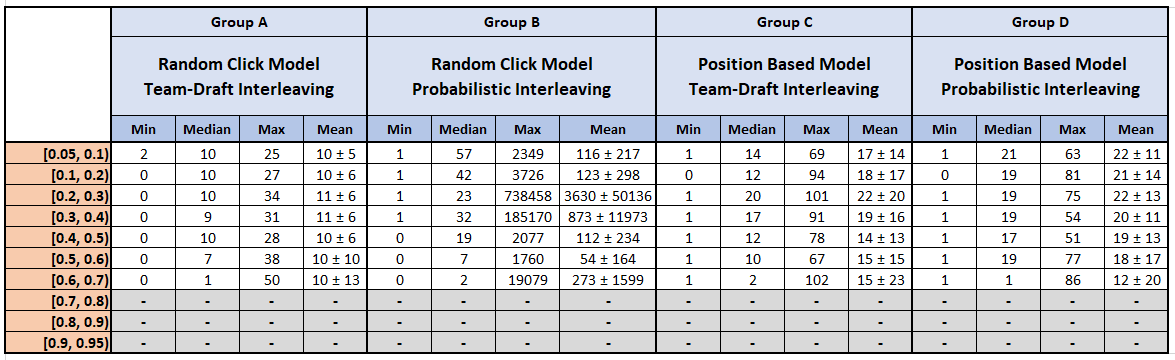

## The PBM ourperformed the RCM in user simulation

To validate whether the PBM captures actual user behaviour to some degree, we used the RCM as a control and compared the proportion of wins for algorithm E ($p_1$) between all four conditions shown in the tables above (Tables 1, 2, 3 \& 4). We found a statistically significant difference between the two different click models (F (1, 6120) = 1510, p < 0.0001) as determined by a three-way ANOVA. While $p_1$ was constant when using the RCM to simulate user clicks for either interleaving algorithms, between all $\Delta E R R$ groups, we observed a clear pattern when using the PBM. There was a marked increase in $p_1$ that appeared to be proportional with the increase in the value $\Delta E R R$. The results are displayed graphically in Figure 1.

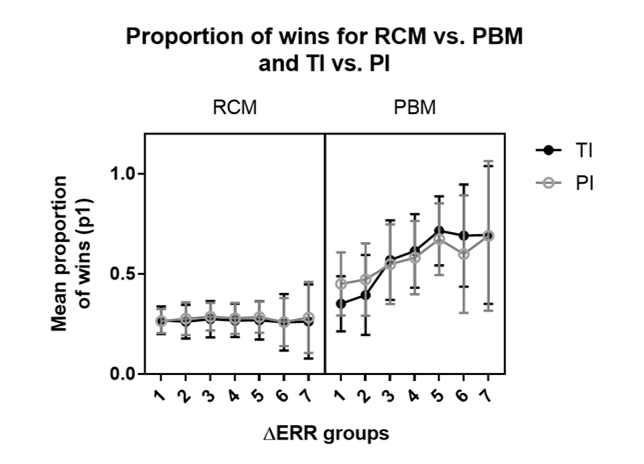
<center><b>Fig.1 </b><i>Line chart showing the mean proportion of wins for algorithm E using the RCM or PBM on interleaved lists after using TI or PI. Error bars denote standard deviation.</i></center>

Therefore we verify that PBM is indeed not random, and does convey useful information about actual user clicking behaviour. The rest of the analysis was done only considering PBM.

## TI and PI did not significantly differ


To assess whether the interleaving part of the experiment contains any bias, we considered and compared $p_1$ when applying TI or PI, using the PBM to simulate clicks. We did observe differences between the interleaving methods however they were not statistically significant, as determined by a two-way ANOVA (F (1, 1396) = 0.07378, p = 0.7860). The results are shown graphically below in Figure 2.

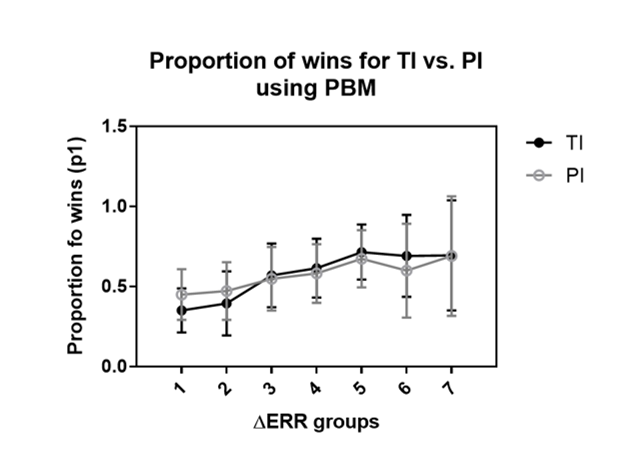
<center><b>Fig.2 </b><i>Line chart showing the mean proportion of wins for algorithm E using the PBM on interleaved lists after using TI or PI. Error bars denote standard deviation.</i></center>

## $\Delta E R R$ is correlated to the proportion of wins ($p_1$)

When using either interleaving algorithm we observed a clear trend of the value of $p_1$ increasing as the margin of performance difference in offline evaluate ($\Delta E R R$) was increasing. 

Using a two-way ANOVA we detected a statistically significant difference in $p_1$ between the $\Delta E R R$ groups for both interleaving algorithms (F (6, 1396) = 112.9, p < 0.0001). A Tukey's multiple comparisons test showed that all $\Delta E R R$ had statistically different values between them for $p_1$ except groups 5,6 and 7 (intervals [0.4, 0.5), [0.5, 0.6) and [0.6, 0.7) respectively). However, this correlation was more pronounced when using the TI algorithm, as we observed a monotonic increase, whereas for PI we detected minor fluctuations.  

The results are shown graphically above, in Figure 2.


## $\Delta E R R$ is weakly negatively correlated with the number of impressions

Having established a link between $\Delta E R R$ and online proportion of wins, we conducted the power analysis using the 1-sample 1-sided proportion test to estimate the minimum number of 
impressions required. We did observe a trend of the number of impressions reducing as $\Delta E R R$ was increasing, and the differences in the number of impressions were statistically significant as determined by a two-way ANOVA test for both interleaving algorithms (F (6, 1431) = 9.759, p < 0.0001). The number of impressions appeared to be negatively correlated to $\Delta E R R$, however, a Tukey's multiple comparisons test showed that only big margin of performance between the algorithms was statistically significant between them. The results are shown graphically below in Figure 3.

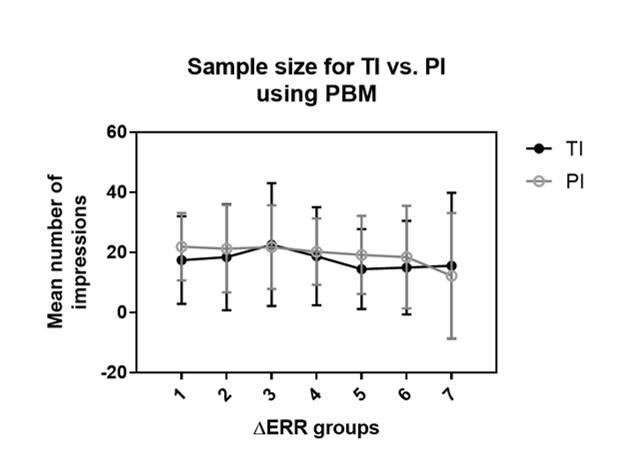
<center><b>Fig.3 </b><i>Line chart showing the mean number of impressions required when using the PBM on interleaved lists after using TI or PI. Error bars denote standard deviation.</i></center>

We can see that the smaller the effect size detected offline, the greatest the number of impressions required to detect a statistically significant difference online, being weakly negatively correlated. Therefore we propose that the offline effect size does convey information about the online effect size.

# Limitations and Future Work(Literature part)

Limitations in our study include the simplicity of the PBM model. Even though we verified that PBM is not random, to implement this model we take a lot of assumptions, therefore may not be representative of actual user behaviour. Also our approach does not allow us to test for sensitivity towards differences between rankers [3]. In a future experiment, we could address the same reaserch question but using actual users or a Dynamic Bayesian network to more accurately capture user behaviour [1][2].

Another limitation of our approach is that for our power analysis and statistical test we assumed the data follow a normal distribution, but we did not test for this. A Shapiro-Wilk test could be used for this purpose.

Finally, to cement our conviction that there is a negative correlation between the offline and online effect size, we may include correlation tests such as the Spearman Correlation Test to get a robust quantification of the correlation between the two.

# Conclusion

In this study examined the funnel approach for search algorithm evaluation, often used by commercial search engines to compare the performance of an experimental  algorithm to the currently applied baseline. Our aim was to determine if the offline part of the procedure is informative of the number of impressions required in the online interleaving experiment, to detect any significant differences in performance between the two algorithms being compared. This would then be useful during the experimental design of such algorithm evaluation procedures, making them more efficient, whilst decreasing user dependency during online testing. We found a visibly clear correlation between the 
margin of the performance difference in offline evaluation and the required number of impressions in online evaluation, however, we did not quantify it. The potential usefulness of the observed correlation for the experimental design of evaluation models remains to be discovered, as factors that are cannot be predicted may affect the effect size in the face of an online, dynamic setting. Robust correlation analysis is required, with actual users being the test subjects instead of using click models to simulate user clicks. The ultimate aim is to develop a closed-form solution to the addressed problem.

# References

[1]  Azarbonyad  and  Kanoulas  (2016).   Power  analysis  forinterleaving experiments by means of offline evaluation.  InICTIR ’16 - Proceedings ofthe 2016 ACM International Conference on the Theory of Information Retrieval, pages 87–90. 2
\\

[2] Chuklin,  A.,  Markov,  I.,  and de Rijke,  M. (2015).Click Models forWeb Search.  Morgan & Claypool. 4
\\

[3] Hoffman, Whiteson, and de Rijke (2011).  Cikm ’11 - a probabilisticmethod for inferring preferences from clicks. InProceedings of the 20th ACM internationalconference on Information and knowledge management, pages 249–258. 4